# 2.1 Getting your data + feature engineering
___

## 2.1.1

*Access to the data found in [this dataset](https://www.kaggle.com/datasets/shivamb/bank-customer-segmentation) (it is the same dataset from the previous question 1.1).*

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

To start from the beginning

In [2]:
tras = pd.read_csv("bank_transactions.csv", parse_dates=['CustomerDOB', 'TransactionDate'])
tras.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,1994-10-01,F,JAMSHEDPUR,17819.05,2016-02-08,143207,25.0
1,T2,C2142763,2057-04-04,M,JHAJJAR,2270.69,2016-02-08,141858,27999.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-02-08,142712,459.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-02-08,142714,2060.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-02-08,181156,1762.5


In [3]:
tras.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1048567 non-null  object        
 1   CustomerID               1048567 non-null  object        
 2   CustomerDOB              1045170 non-null  datetime64[ns]
 3   CustGender               1047467 non-null  object        
 4   CustLocation             1048416 non-null  object        
 5   CustAccountBalance       1046198 non-null  float64       
 6   TransactionDate          1048567 non-null  datetime64[ns]
 7   TransactionTime          1048567 non-null  int64         
 8   TransactionAmount (INR)  1048567 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 72.0+ MB


## Data Cleaning

### Dates
___

<AxesSubplot: >

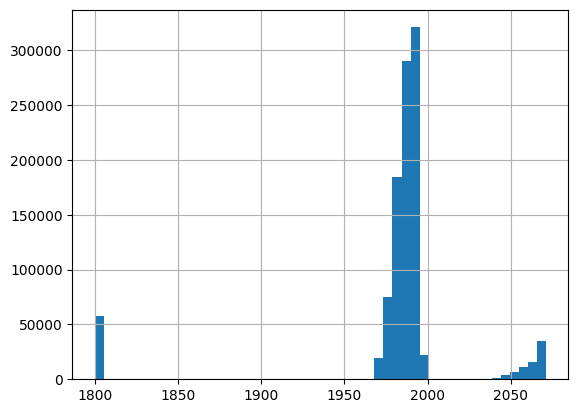

In [4]:
tras.CustomerDOB.dt.year.hist(bins=50)

We can see 
1. people being born in the future => millanium bug
2. people being born in 1800 => we consider there DOB to be unknown

In [5]:
tras.loc[tras.CustomerDOB.dt.year > 2016, 'CustomerDOB'] = \
tras.loc[tras.CustomerDOB.dt.year > 2016, 'CustomerDOB']\
- pd.DateOffset(years = 100)

In [6]:
tras.loc[tras.CustomerDOB.dt.year == 1800, "CustomerDOB"] = pd.NaT

<AxesSubplot: >

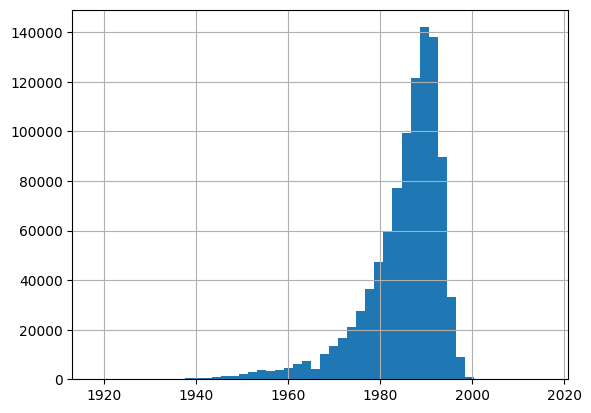

In [7]:
tras.CustomerDOB.dt.year.hist(bins=50)

In [8]:
from datetime import datetime
tras.TransactionTime = tras.TransactionTime.apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))

Missing values are not too many, so we drop them

In [9]:
print('NA rows:',tras.isna().any(axis=1).sum() / tras.shape[0])
tras.dropna(inplace=True)

NA rows: 0.0603156498344884


We now create a new feature that describes the age of the customer when doing the transaction

In [10]:
tras['CustomerAge'] = ((tras.TransactionDate - tras.CustomerDOB).dt.days / 365).round().astype(int)

### Locations
___
We notice that the locations are many and it may be difficult to handle all of them, so we try to clean them up and reduce the number of them, also because many of them are specifications of others, such as `MUMBAI` and `NAVI MUMBAI`.

In [11]:
tras.CustLocation.unique().size

8164

Removing punctuation

In [46]:
import re
tras['CleanLocation'] =\
    tras.CustLocation.apply(lambda loc : re.sub(r'[^\w\s]', '', loc))

Now for every location we search for a shorter name that is present in the dataset. We check if the shorter version is a sub-string of the original name, if yes then we consider it to be the same location.

Also if a city is not very frequent (less than 40 occurences) we assign it to `OTHER`.

In [50]:
unique_locations = tras.CleanLocation.value_counts()
POPULARITY_THRESHOLD = 40
popular_locations =  unique_locations[unique_locations > POPULARITY_THRESHOLD]
unpopular_locations = unique_locations[unique_locations <= POPULARITY_THRESHOLD]

def clean(city):
    parts = city.split()

    for p in parts:
        if p in popular_locations.index:
            return p
        
    return 'OTHER'

mapping = dict(zip(unpopular_locations.index, unpopular_locations.index.map(clean)))
tras.CleanLocation = tras.CleanLocation.map(lambda c: mapping[c] if c in mapping.keys() else c)

We observe that we have succesfully reduced the size of the unique values, by a factor of 10.

In [51]:
tras.CleanLocation.unique().size

962

## 2.1.2

Sometimes, the features (variables, fields) are not given in a dataset but can be created from it. The previous step is known as feature engineering. For example, the original dataset has several transactions done by the same customer. Then, we suggest you to group data by the client (using CustomerId) and, based on it, create the following new features for each CustomerId:

*a) Number of transactions*

*b) Number of transactions with a balance bigger than 100 USD*

*c) Average amount of the transactions*

*d) Average balance*

*e) Average difference between the balance and the transaction amount for each customer (this is mainly known in the banking world as utilisation).*

*f) Most common gender of the customer*

*h) Most frequent location of the customer*

*So, in the end, you should have for each CustomerID seven features.*

In [58]:
custs 

,CustomerAge,CustGender,CleanLocation,CustAccountBalance_avrg,TransactionAmount_avrg (INR)
CustomerID,,,,,
C1010011,24,F,NEW DELHI,76340.635,2553.0
C1010012,22,M,MUMBAI,24204.490,1499.0
C1010014,24,F,MUMBAI,100112.950,727.5
C1010018,26,F,CHAMPARAN,496.180,30.0
C1010024,51,M,KOLKATA,87058.650,5000.0
...,...,...,...,...,...
C9099836,26,M,BHIWANDI,133067.230,691.0
C9099877,20,M,BANGALORE,96063.460,222.0
C9099919,23,M,GUNTUR,5559.750,126.0


In [53]:
custs = tras \
    .groupby('CustomerID')[['CustomerAge', 'CustGender', 'CleanLocation']] \
    .agg(lambda col: col.mode()[0])

In [54]:
custs[['CustAccountBalance_avrg', 'TransactionAmount_avrg (INR)']] = \
    tras.groupby('CustomerID')[['CustAccountBalance', 'TransactionAmount (INR)']].mean()

In [61]:
custs['TransactionNum'] = tras.groupby('CustomerID')['TransactionAmount (INR)'].count()

In [65]:
custs['TransactionNumGT100'] = tras.loc[tras['TransactionAmount (INR)'] > 100].groupby('CustomerID')['TransactionAmount (INR)'].count()
custs.TransactionNumGT100.fillna(0, inplace=True)
custs.TransactionNumGT100 = custs.TransactionNumGT100.astype(int)

In [69]:
tras['utilisation'] = tras.CustAccountBalance - tras['TransactionAmount (INR)']
custs['utilisation'] = tras.groupby('CustomerID')['utilisation'].mean()

custs.to_csv('customers.tsv', sep="\t")
custs.head()

## 2.1.3

Consider at least 20 additional features that can be generated for each CustomerId. Describe each of them and why you believe they will be helpful. Moreover, add it to the previous dataset (the one with seven features). In the end, you should have for each CustomerID at least 27 features (7 recommended + 20 suggested by you).

We engineered the following features:
- Most frequent day of week
- Ever transactioned on weekend

In [109]:
custs['dayOfWeek_Mode'] = tras.groupby('CustomerID')['TransactionDate'].agg(lambda d: d.dt.day_name().mode()[0])
custs['weekend'] = tras.groupby('CustomerID', sort=False)['TransactionDate'].agg(lambda d: any(d.dt.dayofweek >= 5) )

- Average time between transactions

In [103]:
custs['avg_period'] = tras.groupby('CustomerID')['TransactionDate'].agg(lambda d: ((d.max() - d.min()) / d.count()).total_seconds())

- Was ever in negative balance

In [94]:
custs['NegativeBalance'] = tras[tras.CustAccountBalance <= 0].groupby('CustomerID')['CustAccountBalance'].count()
custs['NegativeBalance'].fillna(0, inplace=True)

- Maximum expense over balance in one transaction
- Mean expense over balance in one transaction

In [170]:
tras['impact'] = (tras['TransactionAmount (INR)'] +.1)/ (tras.CustAccountBalance +1)
custs[['MaxImpact', 'AvgImpact']] = tras.groupby('CustomerID')['impact'].agg([max, 'mean'])

- Max Transaction
- Min Transaction
- Median Transaction
- 25-percentile Transaction
- 75-percentile Transaction
- Standeard Deviation of Transaction

In [107]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

custs[
    ['Max Transaction', 'Min Transaction', 
     'Median Transaction', '25-percentile Transaction', 
     '75-percentile Transaction', 'Standard Deviation Transaction']] = tras \
        .groupby('CustomerID')['TransactionAmount (INR)'] \
        .agg([max, min, 'median', percentile(25), percentile(75), 'std'])

- Median Balance
- Max Balance
- Min Balance
- Standard Deviation of Balance

In [112]:
custs[['Median Balance', 'Max Balance', 'Min Balance', 'Standard Deviation Balance']] = \
    tras.groupby('CustomerID', sort=False)['CustAccountBalance']\
        .agg(['median', max, min, 'std'])

- Season of birth
- Decade of birth

In [126]:
SEASONS = {0: 'Winter', 1:'Spring', 2:'Summer',3:'Fall'}
custs['seasonDOB'] = tras.groupby('CustomerID')['CustomerDOB'].agg('first').map(lambda dob: (dob.month - 1) // 3 ).map(SEASONS)

custs['decadeDOB'] = tras.groupby('CustomerID')['CustomerDOB'].agg('first').map(lambda dob: str(dob.year//10 * 10))

- Most frequent period of day (morning, noon, evening and night)
- Ever transactioned at night

In [133]:
DAY_PERIOD = {0: 'Night', 1: 'Morning', 2:'Afternoon', 3:'Evening'}
tras['transaction_period'] = tras.TransactionTime.map(lambda time: time.hour // 6).map(DAY_PERIOD)
custs['DayPeriodMode'] = tras.groupby('CustomerID')['TransactionTime'].agg(lambda p: p.mode()[0])

custs['NightTransaction'] = tras.groupby('CustomerID', sort=False)['transaction_period'].agg(lambda d: any(d == 'Night') )

In [169]:
custs.fillna(0, inplace=True) # need to fill the NA values of the standard deviation with only one transaction
custs.to_csv('customers_enriched.csv')
custs

,CustomerAge,CustGender,CleanLocation,CustAccountBalance_avrg,TransactionAmount_avrg (INR),TransactionNum,TransactionNumGT100,utilisation,dayOfWeek_Mode,avg_period,...,25-percentile Transaction,75-percentile Transaction,Standard Deviation of Transaction,weekend,Median Balance,Max Balance,Min Balance,Standard Deviation Balance,seasonDOB,NightTransaction
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,24,F,NEW DELHI,76340.635,2553.0,2,2,73787.635,Monday,777600.0,...,1454.50,3651.50,3107.027197,False,76340.635,120180.54,32500.73,61998.988224,Summer,True
C1010012,22,M,MUMBAI,24204.490,1499.0,1,1,22705.490,Sunday,0.0,...,1499.00,1499.00,0.000000,True,24204.490,24204.49,24204.49,0.000000,Summer,False
C1010014,24,F,MUMBAI,100112.950,727.5,2,2,99385.450,Friday,7862400.0,...,488.75,966.25,675.286976,False,100112.950,161848.76,38377.14,87307.619786,Spring,False
C1010018,26,F,CHAMPARAN,496.180,30.0,1,0,466.180,Thursday,0.0,...,30.00,30.00,0.000000,False,496.180,496.18,496.18,0.000000,Spring,False
C1010024,51,M,KOLKATA,87058.650,5000.0,1,1,82058.650,Thursday,0.0,...,5000.00,5000.00,0.000000,False,87058.650,87058.65,87058.65,0.000000,Spring,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C9099836,26,M,BHIWANDI,133067.230,691.0,1,1,132376.230,Friday,0.0,...,691.00,691.00,0.000000,False,133067.230,133067.23,133067.23,0.000000,Fall,True
C9099877,20,M,BANGALORE,96063.460,222.0,1,1,95841.460,Thursday,0.0,...,222.00,222.00,0.000000,False,96063.460,96063.46,96063.46,0.000000,Summer,False
C9099919,23,M,GUNTUR,5559.750,126.0,1,1,5433.750,Thursday,0.0,...,126.00,126.00,0.000000,False,5559.750,5559.75,5559.75,0.000000,Fall,False


## 2.2 Choose your features!
Now that we have this many features we want to apply some dimensionality reduction to it, in order to ease the training of our model later.

We will first perform some preprocessing to our data by making use of the `Pipeline` library of _scikit-learn_, and then apply the PCA.

In [138]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as col_selector
from sklearn.decomposition import IncrementalPCA

In [185]:
custs = pd.read_csv('customers_enriched.csv', index_col='CustomerID')
custs.head()

,CustomerAge,CustGender,CleanLocation,CustAccountBalance_avrg,TransactionAmount_avrg (INR),TransactionNum,TransactionNumGT100,utilisation,dayOfWeek_Mode,avg_period,...,25-percentile Transaction,75-percentile Transaction,Standard Deviation of Transaction,weekend,Median Balance,Max Balance,Min Balance,Standard Deviation Balance,seasonDOB,NightTransaction
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,24,F,NEW DELHI,76340.635,2553.0,2,2,73787.635,Monday,777600.0,...,1454.50,3651.50,3107.027197,False,76340.635,120180.54,32500.73,61998.988224,Summer,True
C1010012,22,M,MUMBAI,24204.490,1499.0,1,1,22705.490,Sunday,0.0,...,1499.00,1499.00,0.000000,True,24204.490,24204.49,24204.49,0.000000,Summer,False
C1010014,24,F,MUMBAI,100112.950,727.5,2,2,99385.450,Friday,7862400.0,...,488.75,966.25,675.286976,False,100112.950,161848.76,38377.14,87307.619786,Spring,False
C1010018,26,F,CHAMPARAN,496.180,30.0,1,0,466.180,Thursday,0.0,...,30.00,30.00,0.000000,False,496.180,496.18,496.18,0.000000,Spring,False
C1010024,51,M,KOLKATA,87058.650,5000.0,1,1,82058.650,Thursday,0.0,...,5000.00,5000.00,0.000000,False,87058.650,87058.65,87058.65,0.000000,Spring,False


Our original dataset has some problems: the columns regarding the logarithms of a quantity suffer from having some `-inf` values, so we cast all of the negative values to 0. This shouldn't be a problem. 

In [240]:
custs.describe()

,CustomerAge,CustAccountBalance_avrg,TransactionAmount_avrg (INR),TransactionNum,TransactionNumGT100,utilisation,avg_period,NegativeBalance,MaxImpact,AvgImpact,Max Transaction,Min Transaction,Median Transaction,25-percentile Transaction,75-percentile Transaction,Standard Deviation of Transaction,Median Balance,Max Balance,Min Balance,Standard Deviation Balance
count,839018.000000,8.390180e+05,8.390180e+05,839018.000000,839018.000000,8.390180e+05,8.390180e+05,839018.000000,8.390180e+05,8.390180e+05,8.390180e+05,8.390180e+05,8.390180e+05,8.390180e+05,8.390180e+05,839018.000000,8.390180e+05,8.390180e+05,8.390180e+05,8.390180e+05
mean,30.420416,1.056321e+05,1.453407e+03,1.174273,0.943205,1.041787e+05,5.785369e+05,0.002510,1.078497e+01,9.218893e+00,1.636700e+03,1.285703e+03,1.439341e+03,1.362358e+03,1.536640e+03,237.885236,1.043380e+05,1.209374e+05,9.174323e+04,1.984145e+04
std,8.442880,7.843302e+05,6.044735e+03,0.435111,0.554204,7.840215e+05,1.858237e+06,0.050157,3.768196e+02,3.451573e+02,6.627324e+03,5.883890e+03,6.029819e+03,5.916571e+03,6.250500e+03,2112.719709,7.825793e+05,8.785526e+05,7.542108e+05,3.134376e+05
min,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,-1.517547e+06,0.000000e+00,0.000000,7.004635e-09,7.004635e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,25.000000,5.364666e+03,1.800000e+02,1.000000,1.000000,4.560395e+03,0.000000e+00,0.000000,8.012312e-03,7.686907e-03,1.950000e+02,1.250000e+02,1.780000e+02,1.631287e+02,1.880000e+02,0.000000,5.299935e+03,5.640640e+03,3.673240e+03,0.000000e+00
50%,28.000000,1.768083e+04,4.749950e+02,1.000000,1.000000,1.663460e+04,0.000000e+00,0.000000,3.182726e-02,2.931723e-02,5.000000e+02,3.590000e+02,4.650000e+02,4.250400e+02,4.990000e+02,0.000000,1.736082e+04,1.917630e+04,1.335720e+04,0.000000e+00
75%,34.000000,5.722422e+04,1.175060e+03,1.000000,1.000000,5.571657e+04,0.000000e+00,0.000000,1.561972e-01,1.384151e-01,1.315000e+03,1.000000e+03,1.154590e+03,1.065000e+03,1.250000e+03,0.000000,5.608183e+04,6.380247e+04,4.478974e+04,0.000000e+00
max,99.000000,1.150355e+08,1.560035e+06,6.000000,6.000000,1.150339e+08,1.451520e+07,2.000000,1.250001e+05,1.250001e+05,1.560035e+06,1.560035e+06,1.560035e+06,1.560035e+06,1.560035e+06,511784.089233,1.150355e+08,1.150355e+08,1.150355e+08,8.134158e+07


Now we build the Pipeline that will handle our preprocessing, as it can be seen it's composed by two parts:
- A `OneHotEncoder` for the **categorical** columns, as otherwise the PCA wouldn't be able to handle them. While in literature this is not optimal and FAMD would have been a better choice, due to shortage of time this is what we implemented.
- A Normalizer for the **numerical** columns, as the PCA works so much better with normalised columns.

In [248]:
# categorical = custs.select_dtypes(exclude=['int', 'float']).columns
# custs[categorical] = custs[categorical].astype('category')

bool_cols = custs.select_dtypes(include=['bool']).columns
custs[bool_cols] = custs[bool_cols].astype('str')

In [266]:
import prince
 
a = prince.FAMD(n_components=18, n_iter=10).fit(custs)
a.transform(custs)

a.explained_inertia_.sum()

MemoryError: Unable to allocate 6.12 GiB for an array with shape (839018, 979) and data type float64

In [261]:
%pip install sklearn==1.1.*

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement sklearn==1.1.* (from versions: 0.0, 0.0.post1)
ERROR: No matching distribution found for sklearn==1.1.*

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: C:\Users\Archimede\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [263]:
from sklearn.preprocessing import MinMaxScaler
preprocess = make_column_transformer(
    (OneHotEncoder(
        handle_unknown='ignore', 
        # min_frequency=1e-3,
        ),col_selector(dtype_exclude=np.number)),
    (MinMaxScaler(), col_selector(dtype_include=np.number))
)
preprocess

ColumnTransformer(transformers=[('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000010F9C6D1ED0>),
                                ('minmaxscaler', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000010F9CA1DDE0>)])

Then we build the final pipeline which includes the PCA, note that we used `IncrementalPCA` because it is able to make use of sparse matrices.

In [265]:
pipe = make_pipeline(
    preprocess,
    IncrementalPCA(n_components=10)
)

pipe.fit(custs)

LinAlgError: SVD did not converge

Finally we see how many features we need to explain the variability of at least 70% of the data.

In [ ]:
n_features = 0
pca_variance = pipe.named_steps['incrementalpca'].explained_variance_ratio_

for i in range(1,len(pca_variance)):
    variance_explained = pca_variance[:i].sum()
    print(f'{i:2} features explain {round(variance_explained*100,1)}% of the data')
    if n_features == 0 and variance_explained > .7:
        n_features = i

 1 features explain 26.3% of the data
 2 features explain 38.5% of the data
 3 features explain 47.8% of the data
 4 features explain 56.4% of the data
 5 features explain 63.1% of the data
 6 features explain 68.3% of the data
 7 features explain 71.9% of the data
 8 features explain 74.1% of the data
 9 features explain 76.0% of the data
10 features explain 77.8% of the data
11 features explain 79.4% of the data
12 features explain 80.8% of the data
13 features explain 82.0% of the data
14 features explain 83.0% of the data
15 features explain 83.9% of the data
16 features explain 84.8% of the data
17 features explain 85.5% of the data
18 features explain 86.1% of the data
19 features explain 86.8% of the data


And we can save the new features as csv.

In [58]:
X = pipe.transform(custs)

reducted_data = pd.DataFrame(X)
# Take only most important features
reducted_data = reducted_data.iloc[:,:n_features]
reducted_data.index = custs.index
reducted_data.to_csv('reducted_data.csv')
reducted_data.head()

,0,1,2,3,4,5,6
CustomerID,,,,,,,
C1010011,1.026374,0.116969,-0.081275,0.030366,0.150238,0.099498,-0.467079
C1010012,-0.367674,0.187829,-0.318898,-0.718129,-0.423124,-0.096773,0.122170
C1010014,1.044230,0.151382,-0.364142,-0.666898,-0.433807,-0.109266,0.094200
C1010018,1.021462,0.091433,-0.073196,0.030904,0.114524,0.065475,-0.240427
C1010024,-0.381817,0.164692,-0.031258,-0.017554,0.129882,0.081558,-0.237350


## 2.3 Clustering!
We will implement K-means through MapReduce and try to get the optimal number of clusters, then we will compare the results with `scikit`'s KMeans++.

We start by importing the necessary libraries and setup of `pyspark`.

In [18]:
# Setup pyspark
# ! sudo apt-get update
# ! sudo mkdir -p /usr/share/man/man1
# ! sudo apt-get install -y openjdk-11-jdk
# ! pip install pyspark
import pyspark
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from functions import k_means, display_clusters
from sklearn.metrics import silhouette_score
from functions import avg_inter_cluster_distance, avg_intra_cluster_distance, elbow
%load_ext autoreload
%autoreload 2

sc = pyspark.SparkContext('local')
sc.setLogLevel('OFF')

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local) created by __init__ at /tmp/ipykernel_13906/3903846619.py:12 

We can visualize in part our dataset by plotting some of the dimensions.

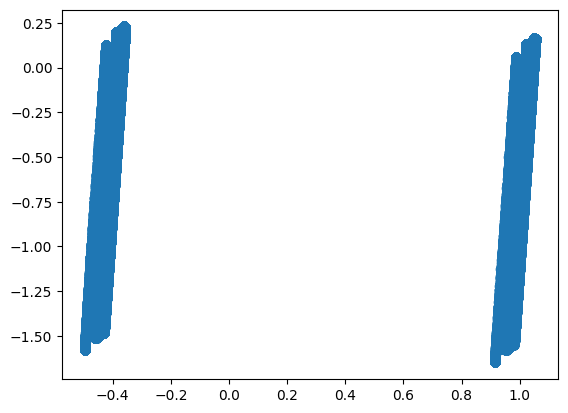

In [8]:
X = pd.read_csv('reducted_data.csv').to_numpy()

plt.scatter(X[:, 0], X[:, 1])
plt.show()

22/12/10 18:51:19 WARN TaskSetManager: Stage 11 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:51:21 WARN TaskSetManager: Stage 12 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


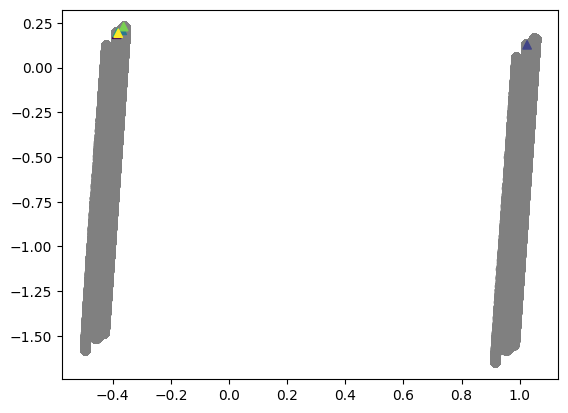

22/12/10 18:51:24 WARN TaskSetManager: Stage 13 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:51:55 WARN TaskSetManager: Stage 14 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:52:22 WARN TaskSetManager: Stage 15 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


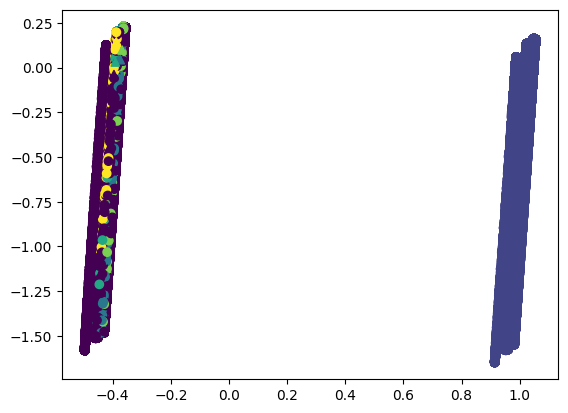

22/12/10 18:53:05 WARN TaskSetManager: Stage 17 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:53:35 WARN TaskSetManager: Stage 18 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:54:02 WARN TaskSetManager: Stage 19 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


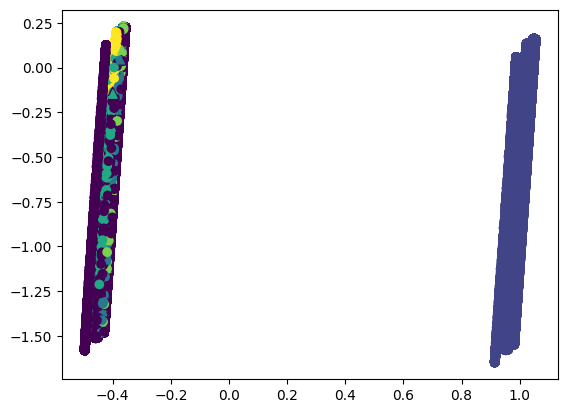

22/12/10 18:54:46 WARN TaskSetManager: Stage 21 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:55:15 WARN TaskSetManager: Stage 22 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:55:40 WARN TaskSetManager: Stage 23 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


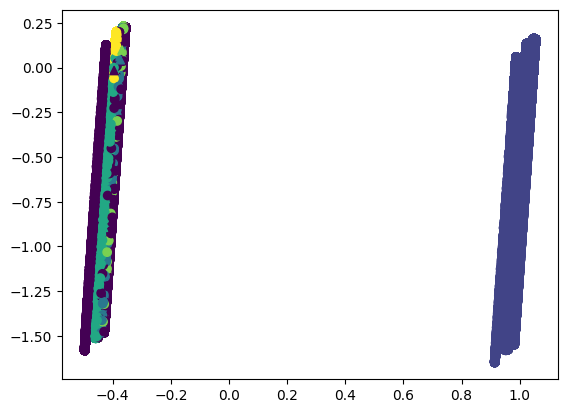

22/12/10 18:56:23 WARN TaskSetManager: Stage 25 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:56:53 WARN TaskSetManager: Stage 26 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:57:20 WARN TaskSetManager: Stage 27 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


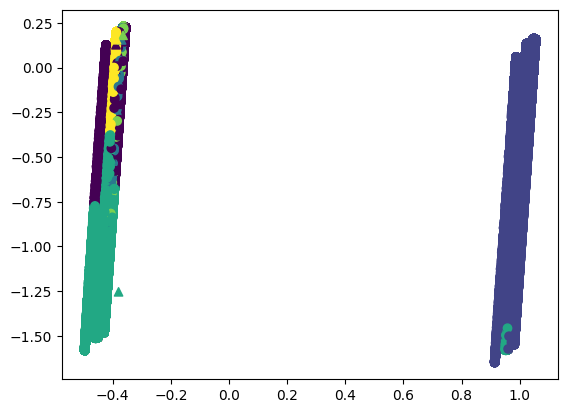

22/12/10 18:58:05 WARN TaskSetManager: Stage 29 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:58:34 WARN TaskSetManager: Stage 30 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 18:59:00 WARN TaskSetManager: Stage 31 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


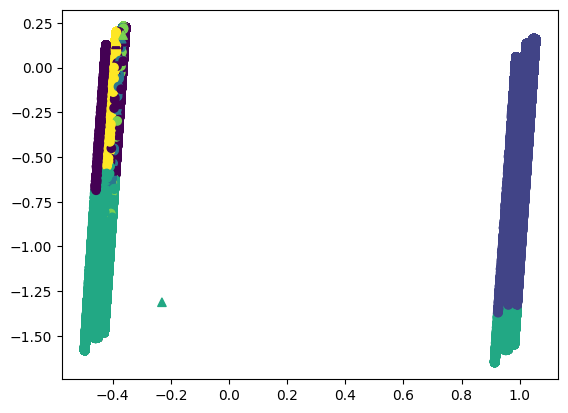

22/12/10 18:59:43 WARN TaskSetManager: Stage 33 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


In [10]:
y, means = k_means(X,6, display=True)

In [35]:
avg_inter_cluster_distance(X,y,means), avg_intra_cluster_distance(X,y,means)

ValueError: operands could not be broadcast together with shapes (78540,7) (2,7) 

We can now start the search for the optimal value of **K**. We will do by grid searching through the values $[2,7]$.

In [12]:
Y = []
means = []
K_VALUES = range(2,11)
for k in K_VALUES:
    y, mean = k_means(X,k, display=False)
    Y.append(y)
    means.append(mean)
    
Y = np.stack(Y)

22/12/10 19:31:27 WARN TaskSetManager: Stage 36 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:31:28 WARN TaskSetManager: Stage 37 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:31:29 WARN TaskSetManager: Stage 38 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


Exception in thread "serve RDD 59" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


22/12/10 19:31:45 WARN TaskSetManager: Stage 39 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:31:58 WARN TaskSetManager: Stage 40 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:32:11 WARN TaskSetManager: Stage 42 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:32:31 WARN TaskSetManager: Stage 43 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:32:32 WARN TaskSetManager: Stage 44 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:32:33 WARN TaskSetManager: Stage 45 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:32:52 WARN TaskSetManager: Stage 46 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:33:07 WARN TaskSetManager: Stage 47 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:33:23 WARN TaskSetManager: Stage 49 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:33:46 WARN TaskSetManager: Stage 50 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:33:47 WARN TaskSetManager: Stage 51 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:33:48 WARN TaskSetManager: Stage 52 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:34:10 WARN TaskSetManager: Stage 53 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:34:28 WARN TaskSetManager: Stage 54 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:34:47 WARN TaskSetManager: Stage 56 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:35:09 WARN TaskSetManager: Stage 57 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:35:27 WARN TaskSetManager: Stage 58 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:35:47 WARN TaskSetManager: Stage 60 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:36:08 WARN TaskSetManager: Stage 61 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:36:26 WARN TaskSetManager: Stage 62 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:36:46 WARN TaskSetManager: Stage 64 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:37:11 WARN TaskSetManager: Stage 65 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:37:12 WARN TaskSetManager: Stage 66 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:37:14 WARN TaskSetManager: Stage 67 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:37:38 WARN TaskSetManager: Stage 68 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:38:00 WARN TaskSetManager: Stage 69 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:38:22 WARN TaskSetManager: Stage 71 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:38:47 WARN TaskSetManager: Stage 72 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:39:08 WARN TaskSetManager: Stage 73 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:39:30 WARN TaskSetManager: Stage 75 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:39:55 WARN TaskSetManager: Stage 76 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:40:17 WARN TaskSetManager: Stage 77 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:40:41 WARN TaskSetManager: Stage 79 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:41:14 WARN TaskSetManager: Stage 80 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:41:15 WARN TaskSetManager: Stage 81 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:41:17 WARN TaskSetManager: Stage 82 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:41:48 WARN TaskSetManager: Stage 83 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:42:16 WARN TaskSetManager: Stage 84 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:42:45 WARN TaskSetManager: Stage 86 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:43:15 WARN TaskSetManager: Stage 87 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:43:40 WARN TaskSetManager: Stage 88 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:44:07 WARN TaskSetManager: Stage 90 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:44:37 WARN TaskSetManager: Stage 91 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:45:03 WARN TaskSetManager: Stage 92 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:45:31 WARN TaskSetManager: Stage 94 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:45:59 WARN TaskSetManager: Stage 95 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:46:24 WARN TaskSetManager: Stage 96 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


22/12/10 19:46:50 WARN TaskSetManager: Stage 98 contains a task of very large size (70582 KiB). The maximum recommended task size is 1000 KiB.


ValueError: all input arrays must have the same shape

Text(0.5, 0, 'k')

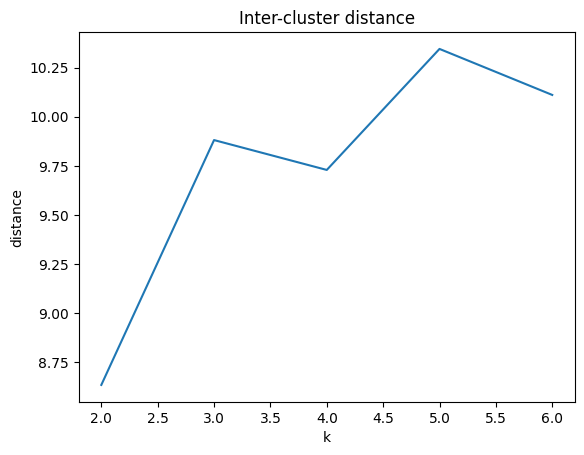

In [27]:
avg_inter_elbow = elbow(avg_inter_cluster_distance, X, Y, means, K_VALUES)
plt.plot(avg_inter_elbow.keys(), avg_inter_elbow.values())
plt.title('Inter-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

Text(0.5, 0, 'k')

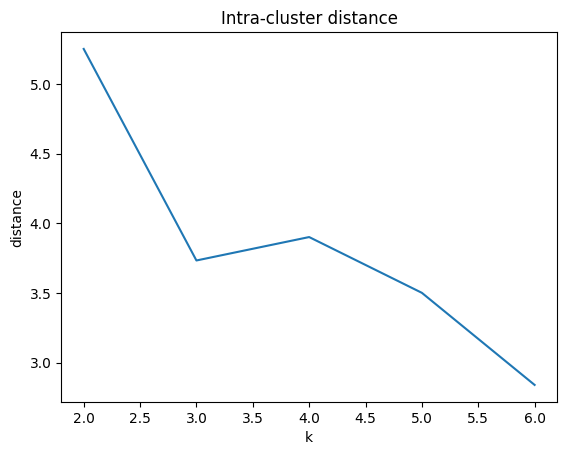

In [29]:
avg_intra_elbow = elbow(avg_intra_cluster_distance, X, Y, means, K_VALUES)
plt.plot(avg_intra_elbow.keys(), avg_intra_elbow.values())
plt.title('Intra-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

In [30]:
silhouette_func = lambda X, k, means: silhouette_score(X,k)
silhouette_elbow = elbow(silhouette_func, X, Y, means, K_VALUES)
plt.plot(cluster_centers_uette_elbow.keys(), silhouette_elbow.values())
plt.title('Silhouette score')
plt.ylabel('score')
plt.xlabel('k')

KeyboardInterrupt: 

So now we can choose the optimal k.

In [31]:
OPTIMAL_K = 5

### Compare against scikit
Now we can confront our algorithm with the KMeans++ from `scikit`

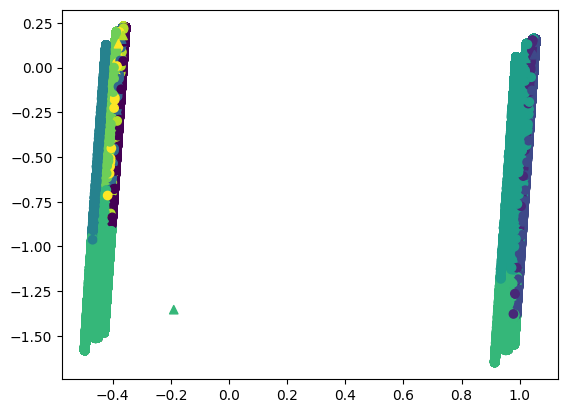

In [59]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=OPTIMAL_K).fit(X)
display_clusters(X, kmeans.labels_, kmeans.cluster_centers_)

In [ ]:
Y_sk = []
means_sk = []
K_VALUES = range(3,20)
for k in K_VALUES:
    km = KMeans(n_clusters=k).fit(X)
    Y_sk.append( km.labels_ )
    means_sk.append( km.cluster_centers_ )
    
Y_sk = np.stack(Y_sk)

Text(0.5, 0, 'k')

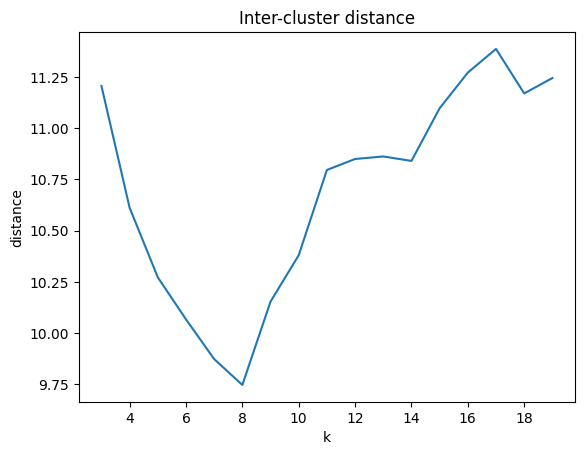

In [44]:
avg_inter_elbow = elbow(avg_inter_cluster_distance, X, Y_sk, means_sk, K_VALUES )
plt.plot(avg_inter_elbow.keys(), avg_inter_elbow.values())
plt.title('Inter-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

Text(0.5, 0, 'k')

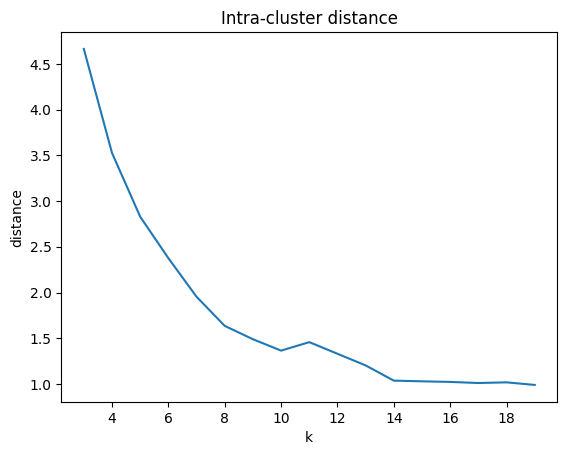

In [45]:
avg_intra_elbow = elbow(avg_intra_cluster_distance, X, Y_sk, means_sk, K_VALUES )
plt.plot(avg_intra_elbow.keys(), avg_intra_elbow.values())
plt.title('Intra-cluster distance')
plt.ylabel('distance')
plt.xlabel('k')

## 2.4 Analysis

## Bonus

In [46]:
from sklearn.cluster import AgglomerativeClustering

birch = AgglomerativeClustering(n_clusters=OPTIMAL_K).fit(X)
display_clusters(X, birch.labels_)

MemoryError: Unable to allocate 2.56 TiB for an array with shape (351975182653,) and data type float64

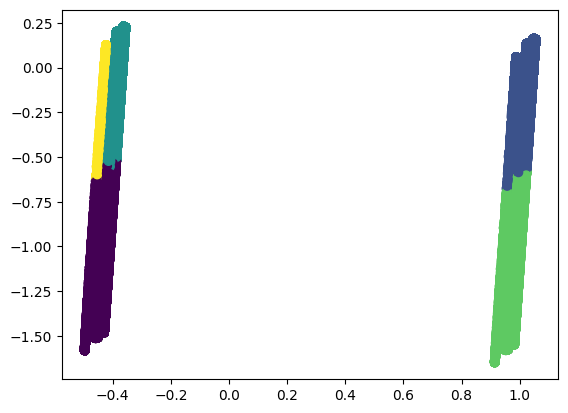

In [43]:
from sklearn.cluster import Birch

birch = Birch(n_clusters=OPTIMAL_K).fit(X)
display_clusters(X, birch.labels_)